In [34]:
# Notebook cell: imports and paths (edit paths to match your environment)
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt

img_dir= 'Images/Images/'
labels_train ='Train.csv'





In [35]:
# Notebook cell: load CSV
df = pd.read_csv(labels_train)
print("CSV shape:", df.shape)
df.head()


CSV shape: (26156, 4)


,image_id,bbox,category_id,id
0,id_w55q2qr62fsk,"[122.0, 1.0, 42.0, 30.0]",2.0,6356.0
1,id_fvldv7o1kn9d,"[500.0, 141.0, 74.0, 70.0]",2.0,2305.0
2,id_5d1r9l1jp7b5,"[304.0, 525.0, 54.0, 58.0]",2.0,238.0
3,id_45qru79t6s4n,"[187.0, 298.0, 44.0, 56.0]",2.0,921.0
4,id_84cjf2pbqmtv,"[349.0, 721.0, 58.0, 59.0]",2.0,1362.0


In [36]:
# Notebook cell: robust bbox parsing (fix TypeError for non-string input)
import re
import pandas as pd

def parse_bbox(bbox_str):
    if not isinstance(bbox_str, str):
        # return None to mark invalid rows
        return None
    # Remove brackets and whitespace, then split
    cleaned = re.sub(r'[\[\]\s]', '', bbox_str)
    vals = cleaned.split(',')
    try:
        vals = [float(x) for x in vals]
    except ValueError:
        return None
    return vals

# Apply parsing
df['bbox_parsed'] = df['bbox'].apply(parse_bbox)

# Drop rows where bbox could not be parsed (NaN or invalid)
df = df.dropna(subset=['bbox_parsed']).reset_index(drop=True)

# Expand into separate columns
df[['xmin','ymin','xmax','ymax']] = pd.DataFrame(df['bbox_parsed'].tolist(), index=df.index)

df.head()


,image_id,bbox,category_id,id,bbox_parsed,xmin,ymin,xmax,ymax
0,id_w55q2qr62fsk,"[122.0, 1.0, 42.0, 30.0]",2.0,6356.0,"[122.0, 1.0, 42.0, 30.0]",122.0,1.0,42.0,30.0
1,id_fvldv7o1kn9d,"[500.0, 141.0, 74.0, 70.0]",2.0,2305.0,"[500.0, 141.0, 74.0, 70.0]",500.0,141.0,74.0,70.0
2,id_5d1r9l1jp7b5,"[304.0, 525.0, 54.0, 58.0]",2.0,238.0,"[304.0, 525.0, 54.0, 58.0]",304.0,525.0,54.0,58.0
3,id_45qru79t6s4n,"[187.0, 298.0, 44.0, 56.0]",2.0,921.0,"[187.0, 298.0, 44.0, 56.0]",187.0,298.0,44.0,56.0
4,id_84cjf2pbqmtv,"[349.0, 721.0, 58.0, 59.0]",2.0,1362.0,"[349.0, 721.0, 58.0, 59.0]",349.0,721.0,58.0,59.0


In [37]:
from pathlib import Path
from PIL import Image

labels_dir = Path("labels_yolo")
labels_dir.mkdir(exist_ok=True)

for _, row in df.iterrows():
    img_name = str(row['image_id']) + ".tif"   # adjust extension if needed
    img_path = Path(img_dir) / img_name
    if not img_path.exists():
        continue
    
    w, h = Image.open(img_path).size
    x1, y1, bw, bh = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    x_c = x1 + bw/2
    y_c = y1 + bh/2


    # normalize
    x_c /= w
    y_c /= h
    bw /= w
    bh /= h
    
    cls = int(row['category_id'])
    label_path = labels_dir / (Path(img_name).stem + ".txt")
    with open(label_path, "a") as f:
        f.write(f"{cls} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")


In [38]:
import random

image_files = [p for p in Path(img_dir).glob("*.tif") if (labels_dir / (p.stem + ".txt")).exists()]
random.shuffle(image_files)

split_idx = int(0.85 * len(image_files))
train_files, val_files = image_files[:split_idx], image_files[split_idx:]

with open("train.txt", "w") as f:
    f.write("\n".join(str(p.resolve()) for p in train_files))
with open("val.txt", "w") as f:
    f.write("\n".join(str(p.resolve()) for p in val_files))

print(f"Train: {len(train_files)}, Val: {len(val_files)}")


Train: 2095, Val: 370


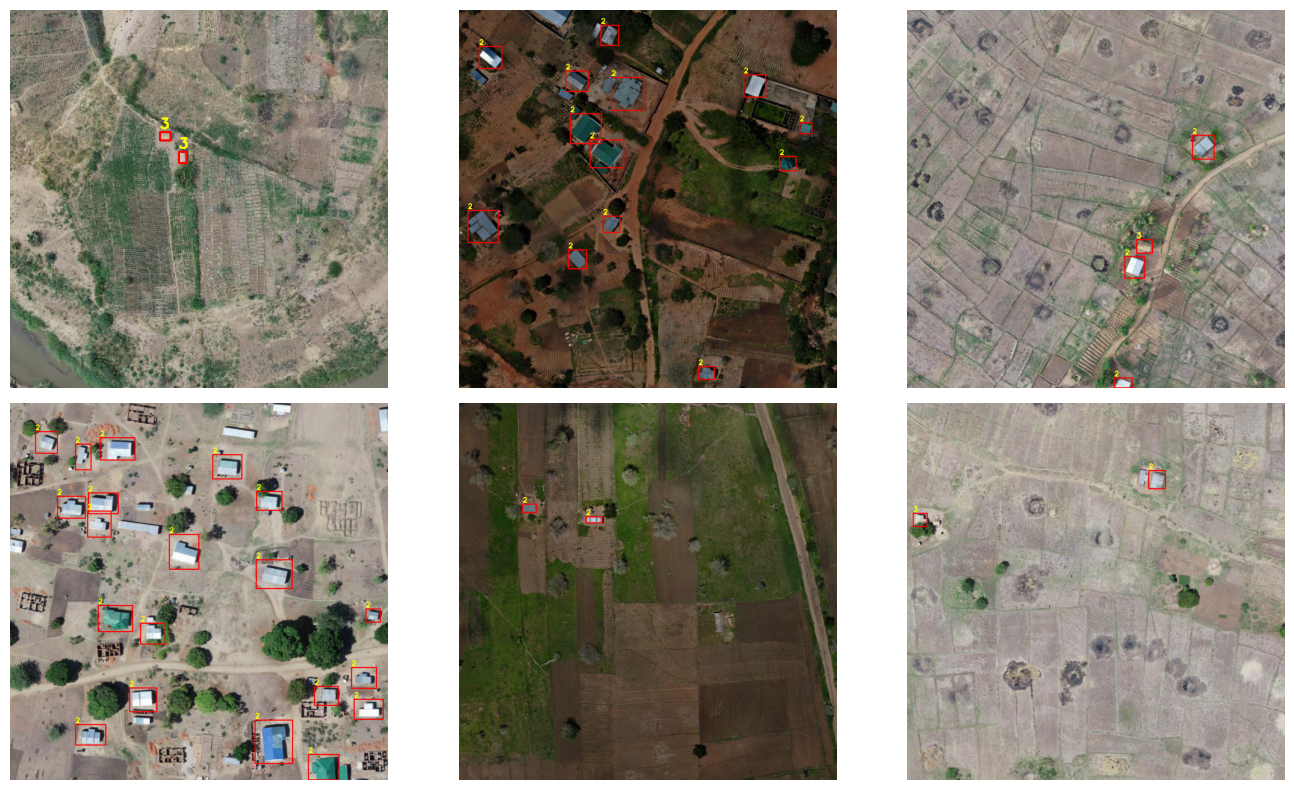

In [39]:
import cv2, matplotlib.pyplot as plt

def show_sample(n=5):
    sample = random.sample(image_files, min(n, len(image_files)))
    plt.figure(figsize=(14,8))
    for i,p in enumerate(sample, 1):
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h,w,_ = img.shape
        lbl = labels_dir / (p.stem + ".txt")
        if lbl.exists():
            for line in open(lbl):
                cls,x,y,ww,hh = line.split()
                x,y,ww,hh = map(float, (x,y,ww,hh))
                x1 = int((x - ww/2) * w); y1 = int((y - hh/2) * h)
                x2 = int((x + ww/2) * w); y2 = int((y + hh/2) * h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(img, cls, (x1, max(10,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)
        plt.subplot(2,3,i); plt.imshow(img); plt.axis("off")
    plt.tight_layout()

show_sample(6)


In [40]:
# --- Sanity checks before splitting / training ---
from pathlib import Path
from collections import Counter
import random

# assume labels_dir and img_dir and image_files already defined in your notebook
labels_dir = Path("labels_yolo")   # adjust if your variable name differs
img_dir = Path(img_dir)           # uses your img_dir variable
image_files = [p for p in img_dir.glob("*.tif")]  # all images

# 1) count how many images have labels
labeled_images = [p for p in image_files if (labels_dir / f"{p.stem}.txt").exists()]
unlabeled_images = [p for p in image_files if not (labels_dir / f"{p.stem}.txt").exists()]

print(f"Total images found: {len(image_files)}")
print(f"Images with labels:   {len(labeled_images)}")
print(f"Images missing labels:{len(unlabeled_images)}")

# show up to 10 missing image names
if unlabeled_images:
    print("\nExample missing images (up to 10):")
    for p in unlabeled_images[:10]:
        print(" -", p.name)

# 2) class distribution from label files (YOLO format: class x y w h)
class_counter = Counter()
num_boxes = 0
example_label = None

for p in labeled_images:
    lab_path = labels_dir / f"{p.stem}.txt"
    with open(lab_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]
    if lines:
        num_boxes += len(lines)
        for ln in lines:
            parts = ln.split()
            try:
                cls = int(float(parts[0]))  # guard against '1.0'
            except:
                cls = parts[0]
            class_counter[cls] += 1
        if example_label is None:
            example_label = (lab_path, lines[:5])

print("\nTotal annotated boxes:", num_boxes)
print("Class distribution (class_id: count):")
for cls, cnt in sorted(class_counter.items()):
    print(f"  {cls}: {cnt}")

# 3) print an example label file
if example_label:
    print("\nExample label file:", example_label[0])
    for ln in example_label[1]:
        print("  ", ln)

# 4) quick check: are class ids zero-based or one-based in your txts?
unique_classes = sorted(class_counter.keys())
if unique_classes:
    print("\nUnique class ids in label files:", unique_classes)
    if min(unique_classes) == 0:
        print(" -> Labels already zero-based (good for YOLO).")
    elif min(unique_classes) == 1:
        print(" -> Labels are 1-based; we'll need to subtract 1 when generating final labels or during conversion.")
    else:
        print(" -> Unexpected class ids; inspect above.")
else:
    print("No classes found in label files. Check label generation step.")


Total images found: 6817
Images with labels:   2465
Images missing labels:4352

Example missing images (up to 10):
 - id_002c1ink0bzw.tif
 - id_00hd0qj051e3.tif
 - id_00qr9gisgz51.tif
 - id_016450pfgcpy.tif
 - id_01ry0uzsn2zg.tif
 - id_021jglokzjvq.tif
 - id_02bapdiq65rs.tif
 - id_02c737a2jxs1.tif
 - id_02dk8umyxwiu.tif
 - id_02i24ur4bt4i.tif

Total annotated boxes: 23849
Class distribution (class_id: count):
  1: 171
  2: 21330
  3: 2348

Example label file: labels_yolo\id_00swku56d3h0.txt
   2 0.129000 0.284000 0.054000 0.056000

Unique class ids in label files: [1, 2, 3]
 -> Labels are 1-based; we'll need to subtract 1 when generating final labels or during conversion.


In [41]:
from pathlib import Path
from collections import Counter

labels_dir = Path("labels_yolo")

cnt = Counter()

for txt in labels_dir.glob("*.txt"):
    for ln in open(txt):
        parts = ln.strip().split()
        if len(parts) == 5:
            cnt[int(float(parts[0]))] += 1
            
print("Classes detected:", sorted(cnt.keys()))


Classes detected: [1, 2, 3]


In [42]:
# Convert YOLO label files from 1-based classes to 0-based classes
from pathlib import Path

labels_dir = Path("labels_yolo")

converted = 0
for txt in labels_dir.glob("*.txt"):
    lines = open(txt).read().strip().split("\n")
    new_lines = []
    for ln in lines:
        parts = ln.split()
        cls = int(float(parts[0])) - 1  # convert 1→0, 2→1, 3→2
        new_line = " ".join([str(cls)] + parts[1:])
        new_lines.append(new_line)
    with open(txt, "w") as f:
        f.write("\n".join(new_lines))
    converted += 1

print(f"Converted {converted} label files to zero-based classes ✔")


Converted 2465 label files to zero-based classes ✔


In [43]:
from pathlib import Path

img_dir = Path(img_dir)  # your folder "Images/Images/"
labels_dir = Path("labels_yolo")

train_images = [p for p in img_dir.glob("*.tif") if (labels_dir / f"{p.stem}.txt").exists()]

print("Train images with labels:", len(train_images))
print("Example:", train_images[:5])


Train images with labels: 2465
Example: [WindowsPath('Images/Images/id_00swku56d3h0.tif'), WindowsPath('Images/Images/id_00w4th51hio0.tif'), WindowsPath('Images/Images/id_015i4fpen1ws.tif'), WindowsPath('Images/Images/id_01gz1pz8e9w6.tif'), WindowsPath('Images/Images/id_02616gseocdo.tif')]


In [44]:
import shutil
import random
from pathlib import Path

# deterministic
random.seed(42)

dataset_root = Path("dataset")
(train_img, val_img, train_lbl, val_lbl) = (
    dataset_root / "images/train",
    dataset_root / "images/val",
    dataset_root / "labels/train",
    dataset_root / "labels/val"
)

# create folders
for d in [train_img, val_img, train_lbl, val_lbl]:
    d.mkdir(parents=True, exist_ok=True)

# split 85/15
split = int(0.85 * len(train_images))
train_set = train_images[:split]
val_set   = train_images[split:]

def copy_pairs(img_list, img_out, lbl_out):
    for p in img_list:
        shutil.copy(p, img_out / p.name)
        shutil.copy(labels_dir / (p.stem + ".txt"), lbl_out / f"{p.stem}.txt")

copy_pairs(train_set, train_img, train_lbl)
copy_pairs(val_set,   val_img,   val_lbl)

print("Train images:", len(train_set))
print("Val images:  ", len(val_set))


Train images: 2095
Val images:   370


In [45]:
yaml_content = """
train: dataset/images/train
val: dataset/images/val

nc: 3
names: ["Other", "Tin", "Thatch"]
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created.")


data.yaml created.


In [1]:
import torch
from ultralytics import YOLO

# Add all required safe globals for PyTorch 2.6+
torch.serialization.add_safe_globals([
    torch.nn.modules.container.Sequential,
    torch.nn.modules.conv.Conv2d,
    torch.nn.modules.pooling.MaxPool2d,
    torch.nn.modules.activation.ReLU,
    torch.nn.modules.batchnorm.BatchNorm2d,
])

# Load YOLO from yaml
model = YOLO("yolov8n.yaml")

# Train
model.train(
    data=r"C:\Users\Mega-PC\Desktop\projet kahyati\data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device=0
)


Ultralytics 8.3.234  Python-3.10.0 torch-2.10.0.dev20251201+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Mega-PC\Desktop\projet kahyati\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train17, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000028E145FBBE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          


image 1/1 C:\Users\Mega-PC\Desktop\projet kahyati\Images\Images\id_0a6iftinl3rj.tif: 640x640 (no detections), 5.0ms
Speed: 2.3ms preprocess, 5.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\Mega-PC\Desktop\projet kahyati\runs\detect\predict5


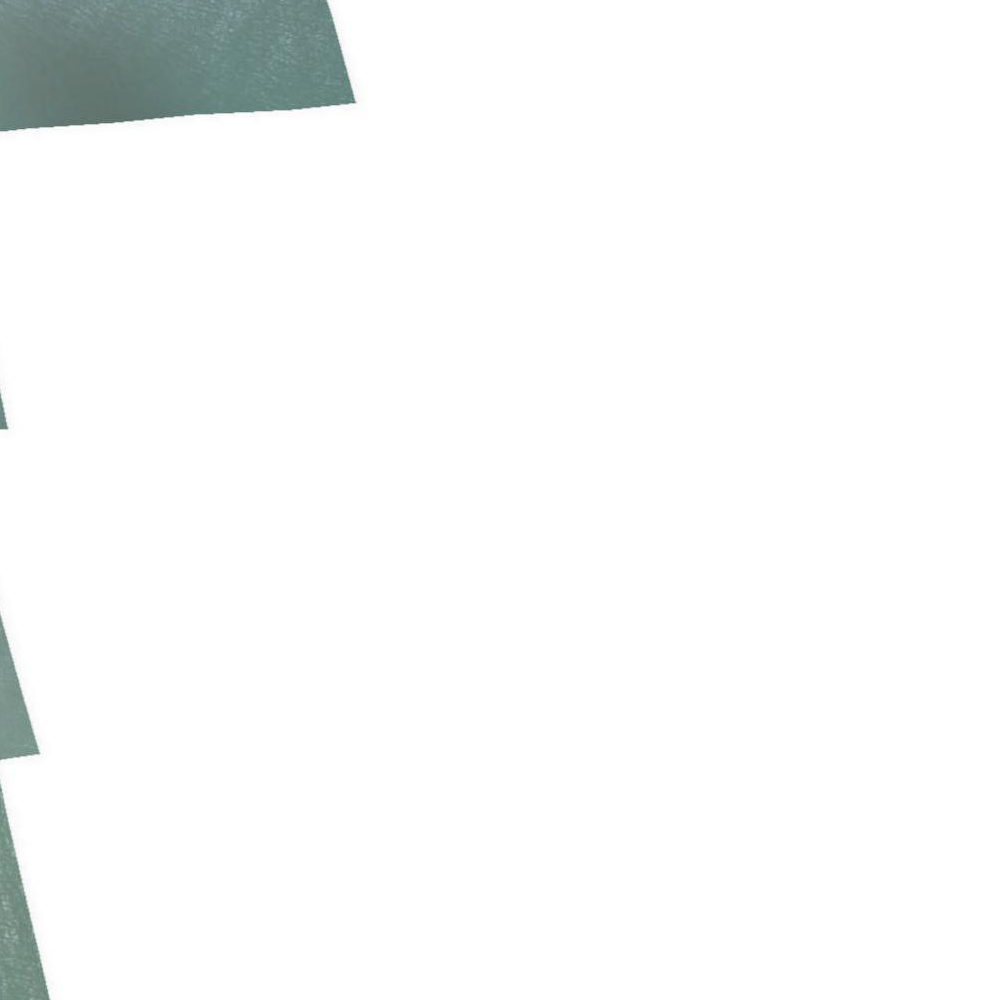


Detections found: 0


In [ ]:
from IPython.display import display
from ultralytics import YOLO
from PIL import Image
import cv2

model = YOLO(r"C:\Users\Mega-PC\Desktop\projet kahyati\runs\detect\train17\weights\best.pt")

results = model.predict(
    source=r"C:\Users\Mega-PC\Desktop\projet kahyati\Images\Images\id_0bw1v0z8nuy3.tif",
    save=True,
    device=0
)

# Get annotated image as numpy array
annotated_img = results[0].plot()

# Convert BGR to RGB and display
img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))

# Show summary
print(f"\nDetections found: {len(results[0].boxes)}")
for i, box in enumerate(results[0].boxes, 1):
    print(f"{i}. {model.names[int(box.cls)]}: {box.conf[0]:.2%}")
